In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib.image import imread
import numpy as np
%matplotlib inline


In [16]:
import os
import json
from skimage.color import rgb2gray
import random

# Get Image Data

In [17]:
image_data_directory = "Dataset/Color"
annotation_url = 'Dataset/annotation.json'

In [4]:
with open(annotation_url) as annotation:
    annotation_data = json.load(annotation)

In [5]:
colors = [
		[100.,  100.,  100.], 
		[100.,    0.,    0.],
		[150.,    0.,    0.],
		[200.,    0.,    0.],
		[255.,    0.,    0.],
		[100.,  100.,    0.],
		[150.,  150.,    0.],
		[200.,  200.,    0.],
		[255.,  255.,    0.],
		[  0.,  100.,   50.],
		[  0.,  150.,   75.],
		[  0.,  200.,  100.],
		[  0.,  255.,  125.],
		[  0.,   50.,  100.],
		[  0.,   75.,  150.],
		[  0.,  100.,  200.],
		[  0.,  125.,  255.],
		[100.,    0.,  100.],
		[150.,    0.,  150.],
        [200.,    0.,  200.],
        [255.,    0.,  255.]]

colors = np.divide(np.array(colors), 255)
print(colors)

[[0.39215686 0.39215686 0.39215686]
 [0.39215686 0.         0.        ]
 [0.58823529 0.         0.        ]
 [0.78431373 0.         0.        ]
 [1.         0.         0.        ]
 [0.39215686 0.39215686 0.        ]
 [0.58823529 0.58823529 0.        ]
 [0.78431373 0.78431373 0.        ]
 [1.         1.         0.        ]
 [0.         0.39215686 0.19607843]
 [0.         0.58823529 0.29411765]
 [0.         0.78431373 0.39215686]
 [0.         1.         0.49019608]
 [0.         0.19607843 0.39215686]
 [0.         0.29411765 0.58823529]
 [0.         0.39215686 0.78431373]
 [0.         0.49019608 1.        ]
 [0.39215686 0.         0.39215686]
 [0.58823529 0.         0.58823529]
 [0.78431373 0.         0.78431373]
 [1.         0.         1.        ]]


In [6]:
def getImageData(image, annotation_data, name):
    if name[-1] == 'L':
        label = 0
    elif name[-1] == 'R':
        label = 1

    pos = np.array(annotation_data[name])
    
    top_left_x = np.amin(pos[:,0]) - 10
    top_left_y = np.amin(pos[:,1]) - 10
    
    width = np.amax(pos[:,0]) - top_left_x + 10
    height = np.amax(pos[:,1]) - top_left_y + 10

    return label, top_left_x, top_left_y, width, height

In [7]:
def plotImageData(image, annotation_data, name):
    if name[-1] == 'L':
        print("L")
    elif name[-1] == 'R':
        print("R")
    plt.figure(figsize=(20,10))
    image = rgb2gray(image)
    plt.imshow(image, cmap='gray')
    pos = np.array(annotation_data[name])
    
    top_left_x = np.amin(pos[:,0]) - 10
    top_left_y = np.amin(pos[:,1]) - 10
    
    width = np.amax(pos[:,0]) - top_left_x + 10
    height = np.amax(pos[:,1]) - top_left_y + 10

    
    rect = patches.Rectangle((top_left_x,top_left_y),width,height,linewidth=1,edgecolor='r',facecolor='none')
    
    plt.gca().add_patch(rect)
    
    plt.scatter(x=pos[:, 0], y=pos[:, 1], c=colors, s=10, alpha=0.7)
    plt.show()
    

In [8]:
def load_part_data(names, data_directory, annotation_data):

    allImages = np.empty((len(names), 1080, 1920))
    allBoxs = np.empty((len(names), 4))
    allLabels = []
    
    for i in range(len(names)):
        name = names[i]
        greyImage = rgb2gray(imread(data_directory + "/" + name[:-2] + ".jpg"))
        
        image = np.array(greyImage, dtype='float32')
                
        label, top_x, top_y, width, height = getImageData(image, annotation_data, name)        
        boundingBox = np.array([top_x, top_y, width, height])
        newLabel = np.array([label])
        
        allImages[i] = image
        allBoxs[i] = boundingBox
        
        #allImages.append(image)
        allLabels.append(newLabel)
        #allBoxs.append(boundingBox)
    
    print(allImages.shape)
    print(allBoxs.shape)
    
    return allImages, np.concatenate(allLabels), allBoxs
        


In [9]:
def load_data(data_directory, annotation_data):
    names = list(annotation_data.keys())

    print("Get train")
    train_data = np.array(names[:200])
    X_train, Y_train_label, Y_train_box = load_part_data(train_data, data_directory, annotation_data)
    
    
    print("Get valid")
    valid_data = np.array(names[200:400])
    X_val, Y_val_label, Y_val_box = load_part_data(valid_data, data_directory, annotation_data)
    
    print("Get test")
    test_data = np.array(names[400:600])
    X_test, Y_test_label, Y_test_box = load_part_data(test_data, data_directory, annotation_data)
    
    mean_image = np.mean(X_train, axis=0)

    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    """
    for name in names:
        if count > 10:
            break
        image = imread(data_directory + "/" + name[:-2] + ".jpg")
        label, top_x, top_y, width, height = getImageData(image, annotation_data, name)
        plotImageData(image, annotation_data, name)
        count += 1    
    """
    
    return X_train, Y_train_label, Y_train_box, X_val, Y_val_label, Y_val_box, X_test, Y_test_label, Y_test_box

            

In [10]:
X_train, Y_train_label, Y_train_box, X_val, Y_val_label, Y_val_box, X_test, Y_test_label, Y_test_box = load_data(image_data_directory, annotation_data)

Get train
(200, 1080, 1920)
(200, 4)
Get valid
(200, 1080, 1920)
(200, 4)
Get test
(200, 1080, 1920)
(200, 4)


In [11]:
print(X_train.shape)
print(Y_train_label.shape)
print(Y_train_box.shape)
print(X_val.shape)
print(Y_val_label.shape)
print(Y_val_box.shape)
print(X_test.shape)
print(Y_test_label.shape)
print(Y_test_box.shape)

(200, 1080, 1920)
(200,)
(200, 4)
(200, 1080, 1920)
(200,)
(200, 4)
(200, 1080, 1920)
(200,)
(200, 4)


# Image Model

image data will have size N x W x H

N = number of images
W = width
H = height

notice that we dont have any a new dimension C that contains RGB values because RGB values
wont affect much in this case.



In [12]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [loss_val,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]

    return total_loss,total_correct

In [13]:
def mymodel(X, y, is_training):
    return

In [14]:
# remove old variables

tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 1080, 1920])
Y_label = tf.placeholder(tf.int32, [None])
Y_box_pos = tf.placeholder(tf.int32, [None, 4])
is_training = tf.placeholder(tf.bool)


In [19]:
X_train.shape

(200, 1080, 1920)

In [21]:
X_train[0].shape

(1080, 1920)

In [23]:
from skimage.transform import resize


In [58]:
bottle_resized = resize(X_train[0], (X_train[0].shape[0] / 5, X_train[0].shape[1] / 5))

C:\Users\Wei Han Chen\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


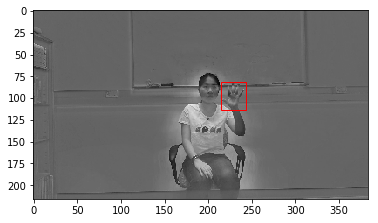

In [62]:
image = rgb2gray(bottle_resized)
plt.imshow(image, cmap='gray')

rect = patches.Rectangle((trying[0],trying[1]),trying[2],trying[3],linewidth=1,edgecolor='r',facecolor='none')

plt.gca().add_patch(rect)

plt.show()

In [59]:
bottle_resized.shape

(216, 384)

In [60]:
trying = Y_train_box[0] / 5

In [61]:
trying

array([214.4612,  81.4048,  29.0832,  32.0704])